# Estimation of the infection profile: Latent(we actually used the Incubation) + Infectious Period
#---Using convolution
#--Author Imelda Trejo 
#-Last updated: Nov  09, 2022

In [8]:
# Import relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.stats import expon
from scipy.stats import gamma
from scipy.stats import weibull_min
from matplotlib import cm
from scipy.integrate import simpson


In [2]:
plt.rcParams.update({'font.size':16})
colors = cm.plasma(np.linspace(0,1,12))

In [3]:
#------integration variables---
T=1300            #time interval [0,n]
h=0.1            #step size of intergation 
tp=int(T/h)+1    #total points
t=np.zeros(tp)
for k in range(1,tp):
    t[k]=h*k
print(tp)

13001


In [9]:
##--- Convolution Q*P: using the trapezoidal rule     
def ConvF(P,Q,h):   
    m,mq=np.size(P),np.size(Q)
    A,v=np.zeros((m-1,m-2)),np.zeros(m)
    if m==mq:
        for k in range(0,m-2):  
            A[m-2-k,k:]=P[1:m-1-k] 
        v[1:]=h*(2*np.dot(A,np.flip(Q[1:m-1]))+P[0]*Q[1:m]+Q[0]*P[1:m])/2
    else:
        print('error')
    return v

##-------Generate auxiliar matrices: A,W, dx=0.1
def MatrixA(Q):   
    n,m=int(np.size(Q)/10),10 #1/h
    A=np.zeros((n,m+1))
    for k in range(1,n):
        for i in range(0,m+1):
            #A[k-1,i]=np.trapz(Q[m*(k-1)+i:m*k+i+1],dx=.1)  #Trapezoidal approx 
            A[k-1,i]=simpson(Q[m*(k-1)+i:m*k+i+1],dx=.1)  #Trapezoidal approx 
    return A

def MatrixW(Q):   
    tp,m=int(np.size(Q)),10 #m=1/h
    W=np.zeros(tp)
    W[0]=Q[0]
    for j in range(1,m+1):
        W[j]=Q[j]
    for j in range(m+1,tp):
        W[j]=Q[j]-Q[j-m]  
    return W

In [10]:
#---******----------------------Parameters for the latent period (F)----#
F=np.zeros(tp) #laten period
f=np.zeros(tp)
Psi=np.zeros(tp)

#--Lauer20
#lognormal mean = 5.5; sd=2.41 #t,0.418,0,5.5
lnpar1 = 1.621
lnpar2 = 0.418
f=lognorm.pdf(t,lnpar2,0,np.exp(lnpar1))
F=lognorm.cdf(t,lnpar2,0,np.exp(lnpar1))

#--*****----Parameters for the infectious period (g)----#

#from Ferreti et al 2020
#Weibull mean value= 5, sd=1.9
gFerreti= weibull_min.pdf(t,2.826, 0, 5.665)
GFerreti= weibull_min.cdf(t,2.826, 0, 5.665)


GG=1-GFerreti
A=MatrixA(GG)
W=MatrixW(F)
Psi=ConvF(GG,f,h)
np.save('F.npy',F)
np.save('Gaux.npy',GG)
np.save('Psi.npy',Psi)
np.save('A.npy',A)
np.save('W.npy',W)
#print(A)

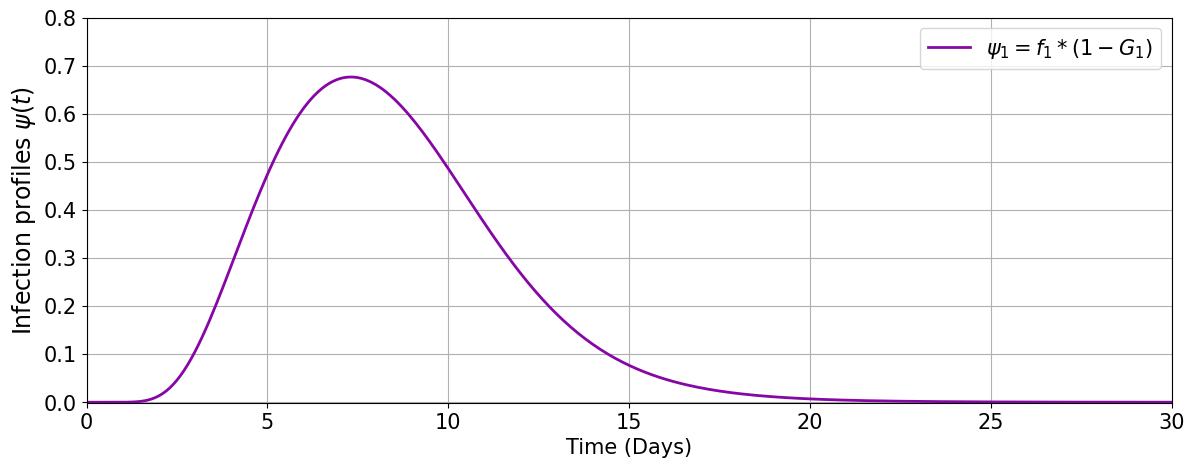

In [11]:
#Visual

fig = plt.figure(figsize=(14,5))

plt.plot(t,Psi,'-',lw=2,color = colors[3],label='$\\psi_1=f_1*(1-G_1)$',alpha=1)


plt.grid(axis='x')
plt.grid(axis='y')

#plt.title("Convolution",fontsize=25)
plt.xlim(0,30)
plt.ylim(-0.001,.8)
plt.xlabel('Time (Days)',fontsize=15) 
plt.ylabel('Infection profiles $\\psi(t)$',fontsize=17) 
plt.tick_params(labelsize=15)
plt.legend(fontsize=15,loc='best')
plt.show()
fig.savefig('Psi.pdf')



In [12]:
#---------statitics-mean and std
m,v=0,0
for k in range(0,tp):
    m=m+h*t[k]*gFerreti[k]  
for k in range(0,tp):
    v=v+h*gFerreti[k]*(m-t[k])**2
print(m,np.sqrt(v))  


5.0461954334923975 1.9348856985870737
